# Zillow Logerror Prediction

## Key Takeaways



## Contents <a name='contents'></a>

*Hyperlinks will only work on locally stored copies of this Jupyter Notebook*

1. <a href='#intro'>Introduction</a>
2. <a href='#wrangle'>Wrangle</a>
    1. <a href='#acquire'>Acquire the Data</a>
    2. <a href='#prepare'>Prepare the Data</a>
3. <a href='#explore'>Explore</a>
    1. <a href='#target'>Looking at the Target Variable</a>
    2. <a href='#geography'>Is `logerror` correlated with geography?</a>
    3. <a href='#clustering'>Using Clustering Algorithms to Explore the Data </a>
    4. <a href='#nongeo_clusters'>Exploring Non-Geographic Clusters </a>
    5. <a href='#geo_clusters'>Exploring Geographic clusters </a>

In [1]:
#imports
#datascience modules
import seaborn as sns
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

#ignore minor warnings
import warnings
warnings.filterwarnings("ignore")

#custom modules
import wrangle_zillow
import explore_zillow

## Introduction <a name='intro'></a>

Zillow data was pulled from the database, and analyzed to determine which features can best determine the logerror of the prediction model. This project is divided into three parts: wrangle, explore, and model. Wrangle explains how the data is acquired and prepared for analysis and processing. Explore looks at the data and applies visualization and hypothesis testing to discover drivers of the logerror.  Clusdtering is used at this stage in order to find groups of rows that are similar. Finally, model builds a model to predict logerror from the data. Each section and select subsections include a short list of key takeaways; these are followed by a discussion detailing the analysis choices made that are relevant to that (sub)section.

### Goals
- Use clustering algorithms to help determine predictors of logerror to help improve the performance of a property value model
- Using drivers of logerror to improve a model of property values
- Improve understanding of logerror to better inform the use of models for property prediction

### Project Plan
- Explore at least four variables of property prices
- Visualize variables
- Hypothesis test at least two variables
- Write this final report
- Python scripts that allow for the project to be reproducible

<a href='#contents'>Back to contents</a>

## Wrangle <a name='wrangle'></a>

### Key Wrangle Takeaways
- $0.66$ of the data is retained, the majority of the dropped data ($0.32$) is from focusing on single unit properties
- Final dataframe has 23 columns and 51606 rows
- There is no missing data in the target `logerror` column

### Acquire the data <a name='acquire'></a>

#### Key Acqure Takeaways
- Data is acquired via `wrangle_zillow.get_zillow_data()`
- Original dataframe is 68 columns and 77414 rows
- There is significant missing data, but none in the `logerror` column

#### Discussion

Data is acquired via the `wrangle_zillow.get_zillow_data()` function. This function will query the SQL database, unless there is a saved .csv file present in the current directory. The name of the file is set by the `wrangle_zillow.FILENAME` constant. This function has the following parameters:

- `query_db = False` (bool) : forces a query to the SQL database even if the .csv file is present.  This will overwrite the existing .csv file.

In order to determine the extent of missing data, `wrangle_zillow.return_col_percent_null()` is used. The function has the followng parameters:

- `df` (DataFrame) : a dataframe containing the Zillow data

This function will return a dataframe with the following columns:

- `column_name` : The name of the column of the relevant column of df
- `percent_null` : The percent of rows in the column_name column of df that are null values
- `count_null` : The total number of null values in the column_name column of df

<a href='#contents'>Back to contents</a>

The first step is to aquire the data via `wrangle_zillow.get_zillow_data()`:

In [2]:
#use get_zillow_data() to acquire the data
df = wrangle_zillow.get_zillow_data()

Returning saved csv file.


Take a look at what the data looks like:

In [3]:
#look at three rows of the dataframe
df.sample(3)

,logerror,transdate,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,typeconstructiondesc,storydesc,propertylandusedesc,heatingorsystemdesc,airconditioningdesc,architecturalstyledesc,buildingclassdesc
69532,0.125888,2017-08-24,1342958,17155360,NaN,NaN,NaN,1.0,2.0,NaN,...,NaN,NaN,6.111004e+13,NaN,NaN,Condominium,NaN,NaN,NaN,NaN
75138,0.022640,2017-09-11,896570,10843799,1.0,NaN,NaN,4.0,5.0,NaN,...,NaN,NaN,6.037128e+13,NaN,NaN,Single Family Residential,Central,Central,NaN,NaN
24826,0.025094,2017-04-10,2816459,14632245,NaN,NaN,NaN,2.0,3.0,NaN,...,NaN,NaN,6.059042e+13,NaN,NaN,Condominium,Yes,NaN,NaN,NaN


Determine the shape of the data, and store it in a variable for later use.

In [4]:
#get the shape attribute of the dataframe and store it in a variable.
original_shape = df.shape
original_shape

(77414, 68)

Use `wrangle_zillow.return_col_percent_null()` to determine the number of null values in each column.

In [5]:
#use return_col_percent_null to get a dataframe with percent and count of null per column
#sort by the percent of the column that is null
null_prop_df = wrangle_zillow.return_col_percent_null(df).sort_values('percent_null')
null_prop_df

,column_name,percent_null,count_null
0,logerror,0.0000,0
1,transdate,0.0000,0
2,id,0.0000,0
3,parcelid,0.0000,0
20,fips,0.0004,33
...,...,...,...
62,storydesc,0.9994,77364
6,basementsqft,0.9994,77364
16,finishedsquarefeet13,0.9995,77373
9,buildingclasstypeid,0.9998,77399


In [6]:
#see some stats on missing data
null_prop_df.describe()

,percent_null,count_null
count,68.000000,68.000000
mean,0.485854,37612.147059
std,0.448192,34696.103056
min,0.000000,0.000000
25%,0.000475,34.750000
50%,0.481200,37249.000000
75%,0.981600,75992.000000
max,0.999800,77399.000000


There is significant missing data in the rows.  A lot of rows will likely not be useful simply because of the amount of missing data.  However, the column of interest, `logerror`, contains no missing data.

<a href='#contents'>Back to contents</a>

### Prepare the Data <a name = 'prepare'></a>

#### Key Prepare Takeaways
- 23 columns and 51606 rows are retained representing $0.66$ of original data
- The majority of the loss is represented by droping non-single unit properties

#### Discussion

Consider the columns that have greater than $0.01$ of the rows having null values. Because there is significant data missing, all of these columns will be dropped.  Note, however, that some of these columns do have the majority of their data.  These columns could be used in a future analysis, see the <a href='#conclusion'>conclusion</a> for more discussion. 

This project is interested in single unit homes.  The column `propertylandusedesc` is filtered so that there is only the following values: `Single Family Residential`,`Mobile Hom`,`Manufactured, Modular, Prefabricated Home`,`Residential Genera`, and `Townhouse`.  Note that this is where the majority of the data is lost, as these rows represent 52495 of the original dataframe of 77414 rows (representing a loss of $0.32 = \frac{77414-52495}{77414}$.  There is a `unitcnt` column; however, it contains a significant number of nulls that are concentrated in Ventura and Orange counties.

The `fips` and `latitude`/`longitude` columns data are changed/corrected. The `fips` column is mapped to the strings `Los Angeles`, `Orange` and `Ventura`; it is then renamed `county`.  This aides in human readability. `latitude` and `longitude` are multiplied by $10^{-6}$, so that they represent the correct values for the Los Angeles metro area.

It is important to consider outliers in this discussion.  One option is that they could be dropped.  However, in the previous analysis of the regression model for `taxvaluedollarcnt` this were likely to be where the model was erring.  Therefore, it makes more sense to tag outliers with a boolean flag, and treat them as a subset of the data. <a href='#target'>See exploration of target variable for more information.</a> 

Finally, datatypes are not changed in this case.  This is because of the small size of the dataset (only 55k rows).  If the dataset was significantly larger, there would be performance gains for moving `float64` to some form of `int`. `transdate` could be cast to a `datetime` datatype; however, it is not used in the analysis and is left as is.

Redundant data can also be dropped.  Consider the following columns:
- `calculatedbathnbr` and `fullbathcnt`, the data can be calculated from the other two columns
- `finishedsquarefeet12` is a repetition of `calculatedfinishedsquarefeet`
- `assessmentyear` can calso be dropped as it is all the same value, 2016.
- `roomcnt` contains significant missing values are can be inferred from the seemingly more reliable `bedroomcnt` and `bathroomcnt`

This is all done in the `wrangle_zillow.wrangle_data`, which takes a dataframe produced by `wrangle_zillow.get_zillow_data()` and calls the following functions:
- `filter_properties()` : filters the properties to only the above mentioned single unit properties.
- `handle_missing_values()` : Drops all rows and columns and columns that have greater and $0.01$ of data missing
- `clearing_fips()` : maps `fips` numbers to the correct county name and renames the column to `county`
- `latitude` and `longitude` are corrected by multiplying by $10^{-6}$ directly, not through a function
    
<a href='#contents'>Back to contents</a>

In [7]:
df = wrangle_zillow.wrangle_data(df) #wrangle the data
df.shape[0]/original_shape[0] #get the percentage of the original data retained

0.6666236081328959

$0.66$ of the data is retained after the above preparation.  The full info output on the dataframe is below:

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51606 entries, 0 to 77413
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   logerror                      51606 non-null  float64
 1   transdate                     51606 non-null  object 
 2   id                            51606 non-null  int64  
 3   parcelid                      51606 non-null  int64  
 4   bathroomcnt                   51606 non-null  float64
 5   bedroomcnt                    51606 non-null  float64
 6   calculatedfinishedsquarefeet  51606 non-null  float64
 7   latitude                      51606 non-null  float64
 8   longitude                     51606 non-null  float64
 9   lotsizesquarefeet             51606 non-null  float64
 10  propertycountylandusecode     51606 non-null  object 
 11  propertylandusetypeid         51606 non-null  float64
 12  rawcensustractandblock        51606 non-null  float64
 13  r

<a href='#contents'>Back to contents</a>

## Exploration <a name='explore'></a>

### Key Explore Takeaways
- Outliers for `logerror` are flagged with a boolean
- Outliers for `logerror` are more likely in Los Angeles, but Orange county has a higher mean `logerror`
- The KMeans clustering algorithm is run twice; once using geographic data, and once without it.
    - Both times there was a definite geographic split: East/West and Downtown/Suburbs
    - Both times there was a stratification based on the `yearbuilt` column

### Exploration Introduction

In the exploration stage of the analysis, data is split into subsets to prevent data leakage, the target variable is understood, and then multivariate analysis is also performed on a series of question.  For each question, there is a series of key takeaways, followed by a discussion with visualizations, and concluded by a series of hypothesis tests.  All hypothesis testing is done with a $0.95$ confidence interval ($α=0.05$).

The following `explore_zillow` custom module functions are used:
- `t_test_by_cat()` : performs a two-tailed, one sample t-test for a categorical variable over a continuous variables.  It splits the dataframe into the subcategories of the categorical variable and tests every combination with the continuous variables. It has the following parameters
    - `df` (DataFrame) : A dataframe containing the columns to be tested
    - `columns_cat` (list) : A list of categorical columns to be tested
    - `columns_cont` (list) : A list of continuous variables to be tested
- `t_test_by_cat_greater()` : same as `t_test_by_cat()` but performs a single tailed t-test where the alternative hypothesis is that the continous variable's mean is greater.  It uses the same parameters.
- `t_test_greater()` : performs a single tailed t-test on the hypothesis that the continous variable has a greater mean.  It has the following inputs:
    - `df` (Dataframe) : a dataframe containing the relevant information
    - `column_cat` (string) : name of the categorical variable
    - `subcat_val` (string) : name of the category within `column_cat`
    - `column_cont` (string) : name of the continuous variable to test
    

### Splitting Data Into Subsets

The data is split into three subsets to prepare for exploration and modeling.  This is done with the `wrangle_zillow.split_data()` function which has the following parameters:
- `df` (DataFrame) : the dataframe to split
- `return_info` (bool) : returns a dataframe with the number of rows and columns of the returned dataframes.

In [9]:
# split the data into train, validate and test subset
train, validate, test, info_df = wrangle_zillow.split_data(df, return_info=True)
info_df.set_index('subset')

,rows,columns
subset,,
train,28898,23
validate,12386,23
test,10322,23


<a href='#contents'>Back to contents</a>

### Looking at the Target Variable: `logerror` <a name='target'></a>

#### Key Target Variable Takeaways
- `logerror` is normally distributed
- Outliers are not dropped, but they are flagged by the `is_outlier` column

#### Discussion

`logerror` is normally distributed with significant outliers. Therefore it makes sense to flag these outliers in a seperate column, `is_outlier` for the rest of the exploratory data analysis.  Outliers here are defined by the <a href='https://en.wikipedia.org/wiki/Interquartile_range#Outliers'>interquartile rule</a>. This is apparent in the following histogram, boxplot and numeric data.

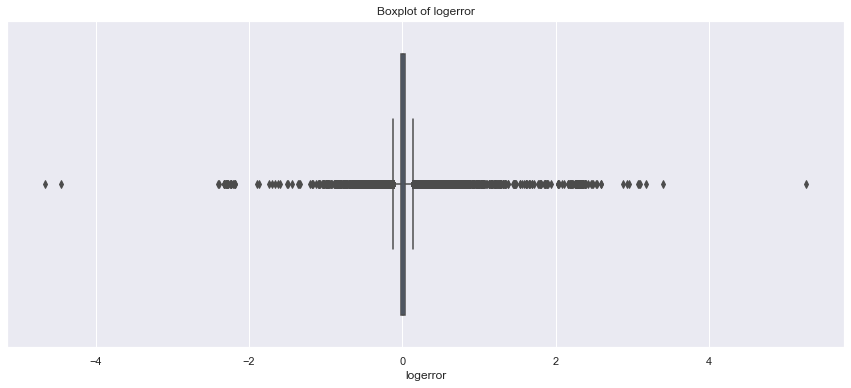

In [10]:
# plot a boxplot of the logerror
explore_zillow.plot_boxplot(df, column_name='logerror', title_str='Boxplot of logerror')

There are a lot of outliers; focus in on the center of the data:

(-0.25, 0.25)

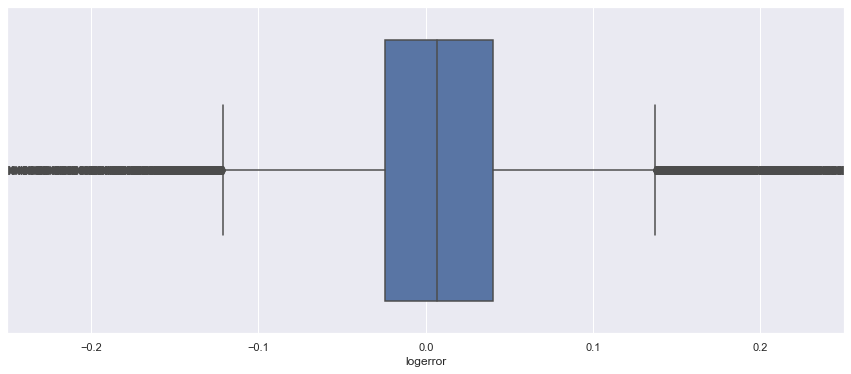

In [66]:
sns.boxplot(data=train, x='logerror') # make a boxplot
plt.xlim((-0.25, 0.25)) # zoom in to see the majority of the data

The median is slightly positive.

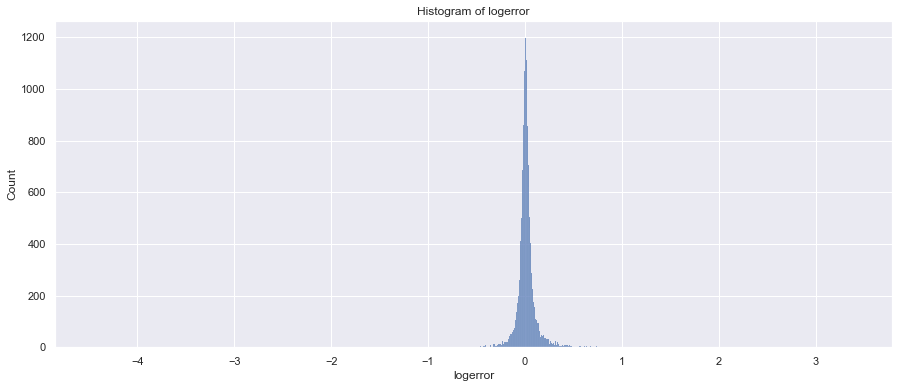

In [11]:
# plot a histogram of the logerror
explore_zillow.plot_histogram(train, column_name='logerror', title_str='Histogram of logerror')

The following numeric data confirms the visualizations.

In [12]:
#same data but numerically
train[['logerror']].describe()

,logerror
count,28898.000000
mean,0.017934
std,0.172092
min,-4.453964
25%,-0.024343
50%,0.006948
75%,0.040230
max,3.394544


The following code calculates the range for the outliers, and then makes the column

In [13]:
#get IQR range for logerror
lower_lim, upper_lim = explore_zillow.return_iqr_outlier_tuple(train, 'logerror')
#make a boolean flag column
train['is_outlier'] = (train['logerror'] < lower_lim) | (train['logerror'] > upper_lim)

In [14]:
train['is_outlier'].mean()

0.1209426257872517

$0.12$ of the data is outliers.  Map these on the histogram, just to show that they are correct:

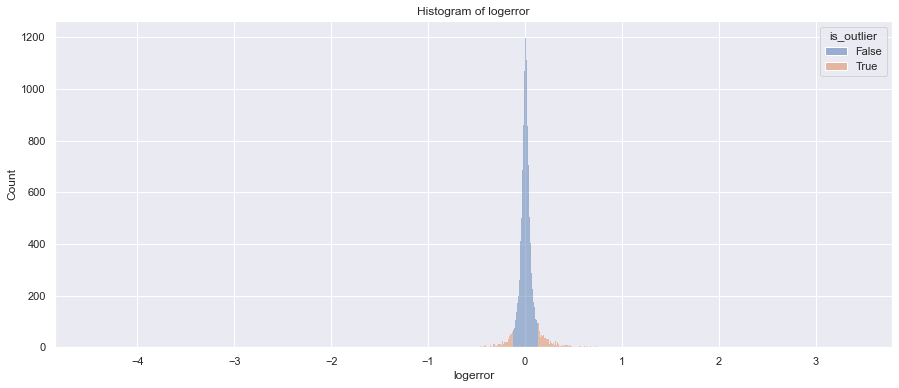

In [15]:
# plot a histogram of the logerror
explore_zillow.plot_histogram(train, column_name='logerror', title_str='Histogram of logerror', hue_column='is_outlier')

<a href='#contents'>Back to contents</a>

### Is `logerror` correlated with geography? <a name='geography'></a>

#### Key Takeaways
- `logerror` outliers are more common in Los Angeles county
- Orange county has a higher mean `logerror` than the other two counties

#### Discussion

Since this is real estate property data, one of the most obvious things to do is to see the grography. This can easily be plotted via the `latitude` and `longitude` data from the data set.  Note that this will produce a stretched map because of the image height and width proportions.

Below, a scatter plot hued by the `is_outlier` column is made, followed by the proportion of the outlier broken down by county.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

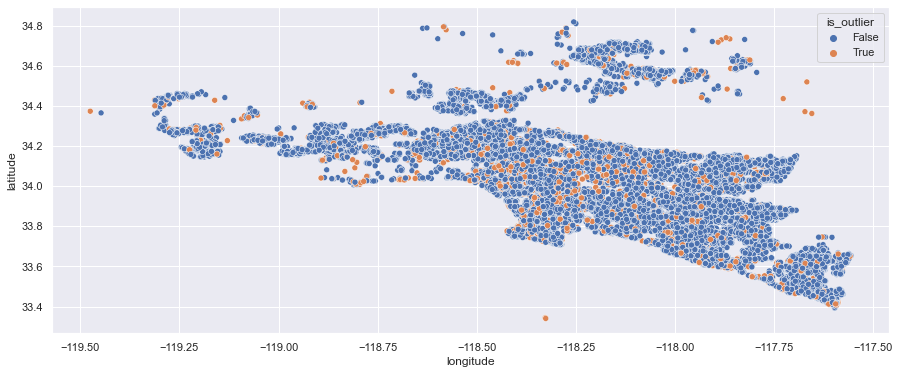

In [16]:
#make a scatter plot for is_outlier
sns.scatterplot(data=train, x='longitude', y='latitude', hue='is_outlier')

In [17]:
# get the proportion of outliers in each county
train.groupby('county')[['is_outlier']].mean()

,is_outlier
county,
Los Angeles,0.140090
Orange,0.086109
Ventura,0.085227


It definitely appears that Los Angeles has a higher number of outliers.  What does the distribution of these outliers by county look like?

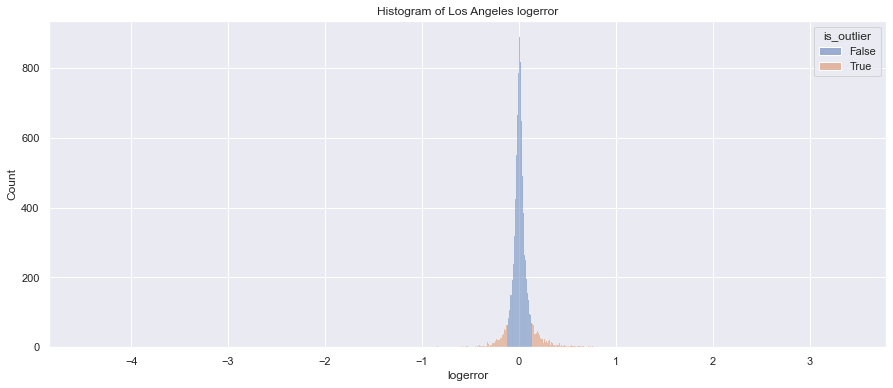

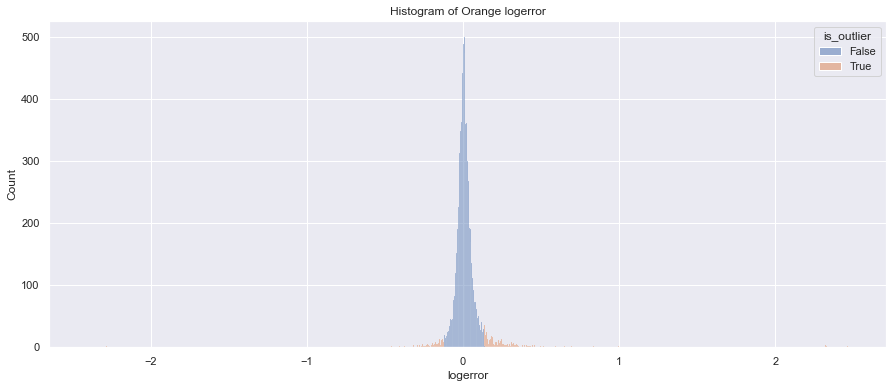

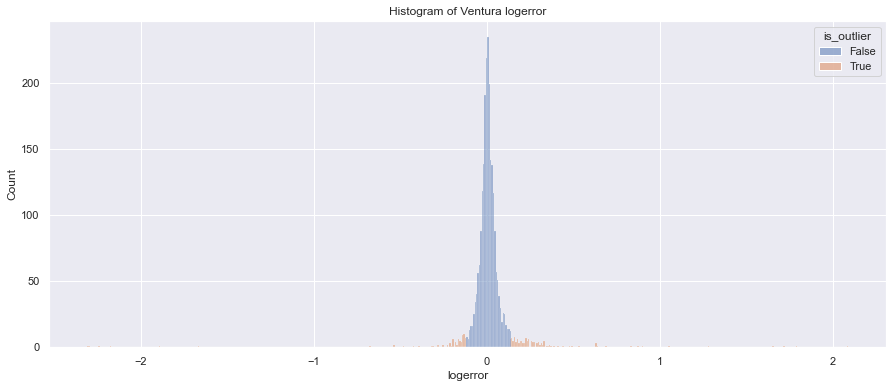

In [18]:
# Make histograms of logerror by county
explore_zillow.plot_histogram(train[train['county']=='Los Angeles'], column_name='logerror', title_str='Histogram of Los Angeles logerror', hue_column='is_outlier')
explore_zillow.plot_histogram(train[train['county']=='Orange'], column_name='logerror', title_str='Histogram of Orange logerror', hue_column='is_outlier')
explore_zillow.plot_histogram(train[train['county']=='Ventura'], column_name='logerror', title_str='Histogram of Ventura logerror', hue_column='is_outlier')

Noting the y-axis range from the above histograms, it is noticeable that the outliers in Los Angeles are more extreme than the other two counties (the Los Angeles histogram has an y-axis range of $(-4, 3)$, rather than $(-2, 2)$.  This can be confirmed numerically:

In [19]:
train.groupby('county')['logerror'].describe()

,count,mean,std,min,25%,50%,75%,max
county,,,,,,,,
Los Angeles,18688.0,0.015470,0.169540,-4.453964,-0.029073,0.006375,0.042369,3.394544
Orange,7746.0,0.025563,0.181707,-2.406257,-0.016722,0.008232,0.037642,2.465684
Ventura,2464.0,0.012644,0.159059,-2.311473,-0.019525,0.005501,0.035345,2.086940


Of note from the above chart is that Orange county has a higher average logerror, and a higher standard deviation.  
#### Hypothesis Testing 

*1. Does Los Angeles county have a higher proportion of outliers in the `logerror` column?*

The following hypotheses are tested via a $χ^2$ test:

$H_0$ : The proportion of outliers in Los Angeles county is the same or less than the proportion of outliers in not-Los Angeles county

$H_a$ : The proportion of outliers in Los Angeles county is greater than the proportion of outliers in not-Los Angeles county

In [20]:
#subset the dataframe
train['is_losangeles'] = train['county'] == 'Los Angeles'
#make crosstab
observed = pd.crosstab(train.is_outlier, train.is_losangeles)
#do stats test
chi2, p, degf, expected = stats.chi2_contingency(observed)
#make output
output = {
    'χ^2':chi2,
    'p-value':p,
    'reject-null':p<0.05
}
#drop created column
train.drop(columns=['is_losangeles'], inplace=True)
#display output
pd.DataFrame([output])

,χ^2,p-value,reject-null
0,181.889441,1.874522e-41,True


$H_0$ is likely false.  Los Angeles probably has a higher proportion of `logerror`.

*2. Does Orange county have a higher mean `logerror`?*

The following hypotheses are tested via a one-tailed t-test:

$H_0$ : Orange county has a mean `logerror` that is less than or equal to not-Orange county mean `logerror`

$H_a$ : Orange county has a mean `logerror` that is greater than not-Orange county mean `logerror`

In [21]:
explore_zillow.t_test_greater(train, column_cat='county', subcat_val='Orange', column_cont='logerror')

,category_name,category_value,t-stat,p-value,reject_null
0,county,Orange,5.048198,4.561611e-07,True


$H_0$ is likely false.  Orange county probably has a higher `logerror` mean.

<a href='#contents'>Back to content</a>

### Using Clustering Algorithms to Explore the Data <a name='clustering'></a>

#### Key Clustering Take Aways
- 6 clusters is optimal
- Clustering looks geographic, even if none of the parameters are geographic
- 2 cluster columns are made `clusters_geo` based on geographic data and `clusters` not based on geographic data

#### Discussion

Besides geography, there may be other groupings of data.  In order to expedite the process of finding useful groups, a clustering algorithm can be used to explore the data.  In order to increase a likelihood of success, the following columns are used for clustering:
- `county` : See discussion <a href='#geography'>above</a> for importance of geography to `logerror`
- `latitude` and `longitude` : Related to the question of geography, but allows for more spatial clustering
- `taxvaluedollarcnt` : Because this is the target variable of the model producing `logerror` it might be useful
- `bathroomcnt` : This was correlated with `taxvaluedollarcnt`
- `calculatedfinishedsquarefeet` : This was also correlated with `taxvaluedollarcnt`
- `yearbuilt` : It might be harder to predict whether or not an older house is valuable or not.  It could be valuable because it is historic and/or renovated (or have potential as a "fixer-upper")

Note that for clustering these must be encoded and scaled.  This is done in the following code:

In [22]:
#subset to the columns to cluster
train_cluster = train[['parcelid', 'county', 'yearbuilt', 'latitude', 'longitude', 'taxvaluedollarcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet']]
#scale and encode the data
train_encoded_scaled = wrangle_zillow.scale_and_encode(train_cluster, columns_to_encode = ['county'], columns_to_scale=['yearbuilt', 'latitude', 'longitude', 'taxvaluedollarcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet'])

Determine the best number of clusters by measuring the intertia:

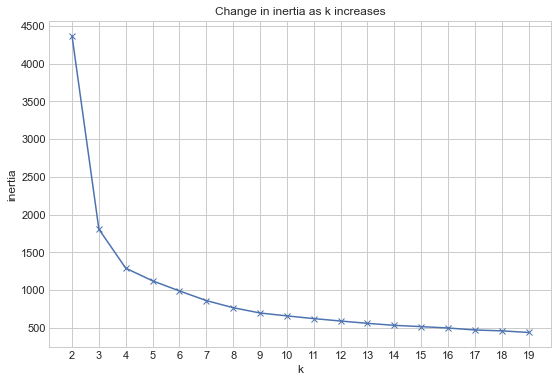

In [23]:
#make an X dataframe without the parcelid
X = train_encoded_scaled.drop(columns = ['parcelid'])
with plt.style.context('seaborn-whitegrid'):
    #plot
    plt.figure(figsize=(9, 6))
    #get inertia for k clusters
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 20)}).plot(marker='x')
    #make labels
    plt.xticks(range(2, 20))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

It looks like 6 clusters is optimum. Make the clusters and add them to the `train` dataframe.

In [24]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
train['cluster_geo'] = kmeans.predict(X)

The clusters as a percent of the data:

In [25]:
train.cluster_geo.value_counts(normalize=True)

1    0.268046
4    0.230189
5    0.163610
2    0.157104
0    0.095785
3    0.085265
Name: cluster_geo, dtype: float64

Now that there are clusters, plot them graphically on a map:

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

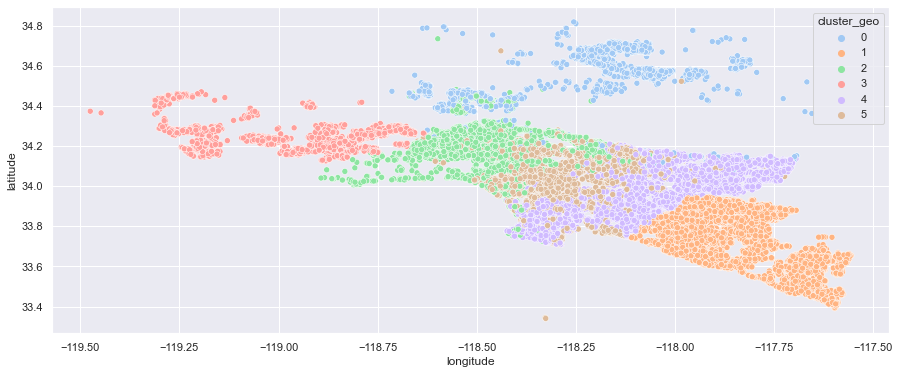

In [26]:
#make a scatter plot for cluster
sns.scatterplot(data=train, x='longitude', y='latitude', hue='cluster_geo', palette = sns.color_palette("pastel", n_colors = 6))

In [27]:
train.groupby('cluster_geo').logerror.describe()

,count,mean,std,min,25%,50%,75%,max
cluster_geo,,,,,,,,
0,2768.0,0.016042,0.126435,-0.447563,-0.022245,0.003906,0.030942,1.772564
1,7746.0,0.025563,0.181707,-2.406257,-0.016722,0.008232,0.037642,2.465684
2,4540.0,0.017865,0.166501,-2.175696,-0.028103,0.010530,0.052222,3.175688
3,2464.0,0.012644,0.159059,-2.311473,-0.019525,0.005501,0.035345,2.086940
4,6652.0,0.022457,0.164500,-4.453964,-0.022752,0.006742,0.038373,3.394544
5,4728.0,0.003004,0.198368,-1.623253,-0.049516,0.002856,0.047293,3.100913


Looks like it is grouping by county.  Check this numerically:

In [28]:
train.groupby('county').cluster_geo.value_counts()

county       cluster_geo
Los Angeles  4              6652
             5              4728
             2              4540
             0              2768
Orange       1              7746
Ventura      3              2464
Name: cluster_geo, dtype: int64

In [29]:
train.groupby('county').cluster_geo.value_counts(normalize=True)

county       cluster_geo
Los Angeles  4              0.355950
             5              0.252997
             2              0.242937
             0              0.148116
Orange       1              1.000000
Ventura      3              1.000000
Name: cluster_geo, dtype: float64

This appears to be a fancy Los Angeles splitter. It could be that the geographic data is overly influencing the data.  Try without geographic data:

In [30]:
#subset to the columns to cluster
train_cluster = train[['parcelid', 'yearbuilt','taxvaluedollarcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet']]
#scale and encode the data
train_encoded_scaled = wrangle_zillow.scale_and_encode(train_cluster, columns_to_encode = None, columns_to_scale=['taxvaluedollarcnt', 'yearbuilt', 'bathroomcnt', 'calculatedfinishedsquarefeet'])

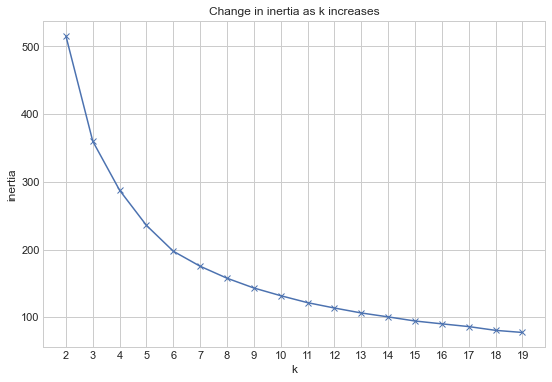

In [31]:
#make an X dataframe without the parcelid
X = train_encoded_scaled.drop(columns = ['parcelid'])
with plt.style.context('seaborn-whitegrid'):
    #plot
    plt.figure(figsize=(9, 6))
    #get inertia for k clusters
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 20)}).plot(marker='x')
    #make labels
    plt.xticks(range(2, 20))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

6 again seems to be a good number to cluster on.

In [32]:
#make the six clusters and then add to the dataframe
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
#add to the dataframe
train['cluster'] = kmeans.predict(X)

The clusters broken down by proportion of the data set:

In [33]:
train.cluster.value_counts(normalize=True)

3    0.339089
0    0.251055
1    0.178109
2    0.102395
5    0.074434
4    0.054917
Name: cluster, dtype: float64

Plot the clusters on the map.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

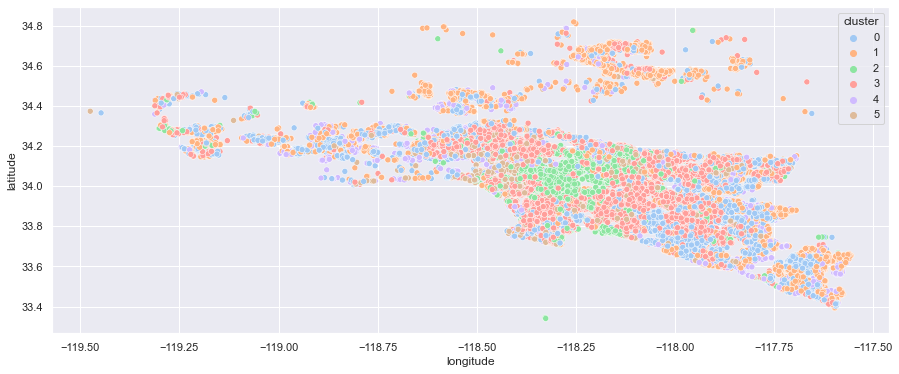

In [34]:
#make a scatter plot for cluster
sns.scatterplot(data=train, x='longitude', y='latitude', hue='cluster', palette = sns.color_palette("pastel", n_colors = 6))

This still looks like it is clustering geographcally, but not at the county or `latitude`/`longitude` level. It might be indicative of a subcounty geographic category.  Look at the clusters numerically.

In [35]:
train.groupby('county').cluster.value_counts()

county       cluster
Los Angeles  3          7941
             0          2903
             2          2757
             1          2509
             5          1857
             4           721
Orange       0          3302
             1          1915
             3          1483
             4           670
             5           242
             2           134
Ventura      0          1050
             1           723
             3           375
             4           196
             2            68
             5            52
Name: cluster, dtype: int64

Every county has at least one member of each cluster, but the proportions look different.  Check this by the proportion in each county:

In [36]:
train.groupby('county').cluster.value_counts(normalize=True)

county       cluster
Los Angeles  3          0.424925
             0          0.155340
             2          0.147528
             1          0.134257
             5          0.099369
             4          0.038581
Orange       0          0.426285
             1          0.247224
             3          0.191454
             4          0.086496
             5          0.031242
             2          0.017299
Ventura      0          0.426136
             1          0.293425
             3          0.152192
             4          0.079545
             2          0.027597
             5          0.021104
Name: cluster, dtype: float64

And now get the log error for the clusters:

In [37]:
train.groupby('cluster').logerror.describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,7255.0,0.019765,0.166065,-2.387800,-0.018645,0.007712,0.036733,3.394544
1,5147.0,0.017127,0.129861,-2.330162,-0.016626,0.006182,0.030805,2.394197
2,2959.0,0.006074,0.215391,-1.179223,-0.051160,0.005070,0.050950,3.100913
3,9799.0,0.015173,0.165203,-4.453964,-0.030076,0.004006,0.038088,3.069365
4,1587.0,0.040560,0.182437,-2.406257,-0.013367,0.022152,0.069443,2.356096
5,2151.0,0.025894,0.226274,-1.897475,-0.028807,0.014642,0.061058,3.175688


<a href='#contents'>Back to contents</a>

### Exploring Non-Geographic Clusters <a name='nongeo_clusters'></a>

#### Key Takeaways
- Clusters 0 and 5 have a higher logerror
- Clusters 0 and 5 have a higher taxvaluedollarcnt
- `yearbuilt` was a good predictor of cluster, with clusters 0 and 5 being older and newer expensive houses, and the rest of the clusters representing some number of years
- It might be beneficial to use a piecewise model for clusters 0 and 5, then a model for the other clusters

#### Discussion

The non geographic clusters are still grouping geographically by county; for example, cluster 2 represents $0.42$ of Los Angeles homes, whereas clusters 3 and 4 are more significant in Orange and Ventura counties.  In addition, ouliers for logerror are in clusters 0 and 1, and these are more represented in Los Angeles--as might be expected because Los Angeles has the highest percentage of outliers (See discussion <a href='#geography'>here</a>).  In addition, cluster 1 does not have a higher `taxvaluedollarcnt`; this is expected as cluster 0 and 5 represent more of the rows in Los Angeles and Orange county--and previous analysis showed that Los Angeles and Orange had higher `taxvaluedollarcnt`.  In addition, clusters were grouped by `yearbuilt`, so the mapping most likely represents the sequence of neighborhoods built around downtown Los Angeles.  Clusters 0 and 5 do not match this trend, but might represent old and new expensive homes.

Overall, this exploration indicates that a piece-wise model might be beneficial; it would use one model for clusters 0 and 5, and another for the rest of the clusters.

Visual exploration is below.

(-0.4, 0.4)

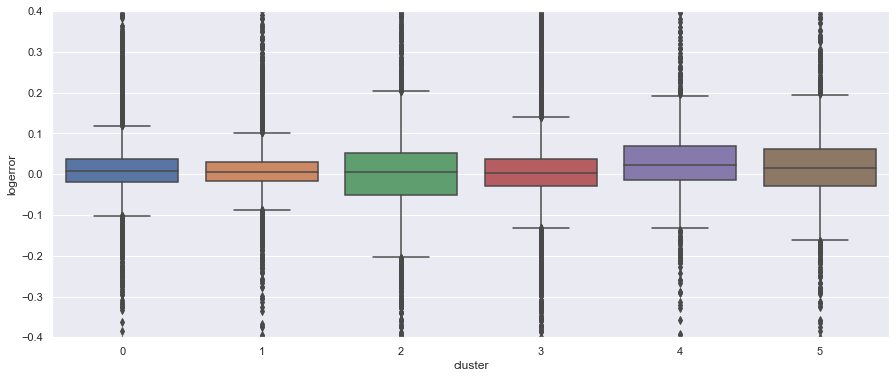

In [38]:
sns.boxplot(data=train, x='cluster', y='logerror') # make a boxplot
plt.ylim((-0.4, 0.4)) # zoom in to see the majority of the data

Clusters 3 and 4 appear more concentrated, and clsuter 5 looks like it has a greater logerror than the others.  Are outliers concentrated in a particular cluster? (Recalling that $\approx 0.12$ of the data is outliers, see <a href ='#target'>here</a>).

In [39]:
train.groupby('cluster').is_outlier.value_counts(normalize=True)

cluster  is_outlier
0        False         0.917436
         True          0.082564
1        False         0.932194
         True          0.067806
2        False         0.763096
         True          0.236904
3        False         0.870905
         True          0.129095
4        False         0.862004
         True          0.137996
5        False         0.831706
         True          0.168294
Name: is_outlier, dtype: float64

In fact it looks like clusters 0 and 1 have a lower amount of outliers.

As stated above, some clusters are more concentrated in some counties:

In [40]:
train.groupby('county').cluster.value_counts(normalize=True)

county       cluster
Los Angeles  3          0.424925
             0          0.155340
             2          0.147528
             1          0.134257
             5          0.099369
             4          0.038581
Orange       0          0.426285
             1          0.247224
             3          0.191454
             4          0.086496
             5          0.031242
             2          0.017299
Ventura      0          0.426136
             1          0.293425
             3          0.152192
             4          0.079545
             2          0.027597
             5          0.021104
Name: cluster, dtype: float64

This is confirmed by plotting them in terms of the latitude and longitude.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

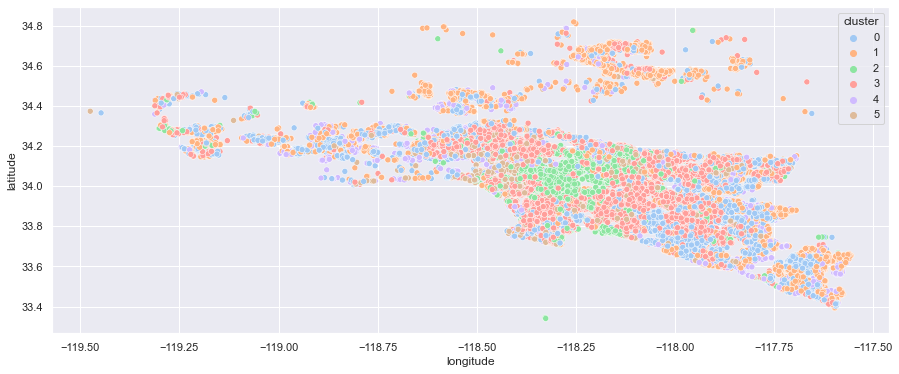

In [41]:
#make a scatter plot for cluster
sns.scatterplot(data=train, x='longitude', y='latitude', hue='cluster', palette = sns.color_palette("pastel", n_colors = 6))

Plot them individually shows this too:

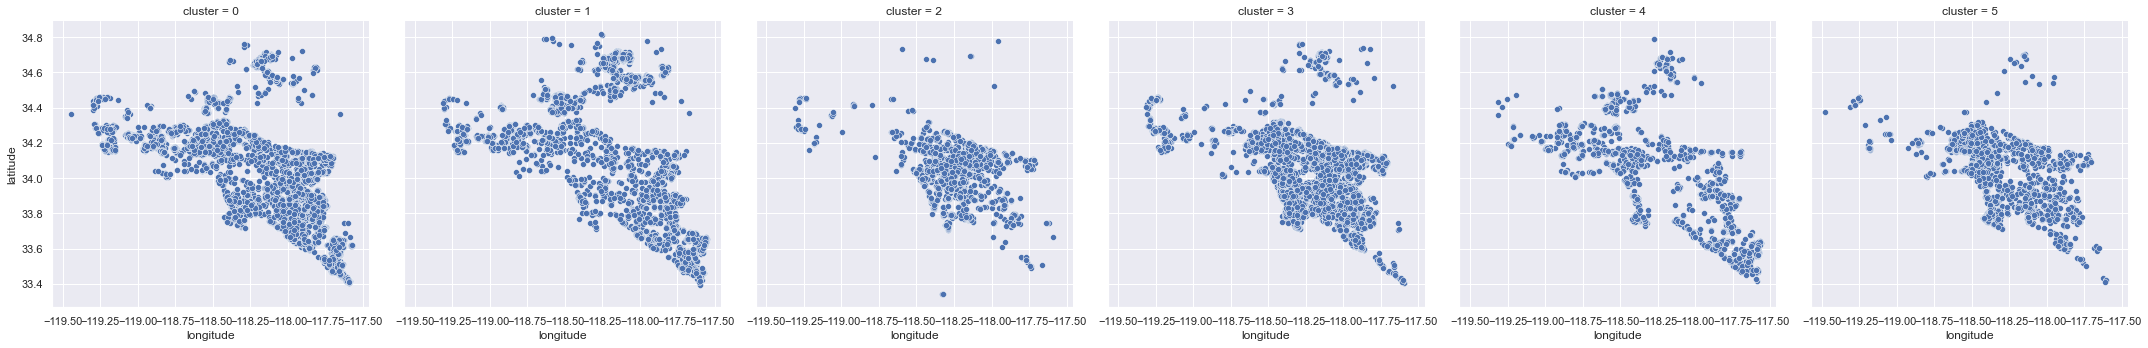

In [72]:
#make a scatter plot for cluster
sns.relplot(data=train, x='longitude', y='latitude', col='cluster', palette = sns.color_palette("pastel", n_colors = 6))

Consider also the underlying target variable that produces the `logerror`, `taxvaluedollarcnt`.  It appears from the boxplot below that clusters 1 and 5 contain more expensive houses.

(0.0, 12000000.0)

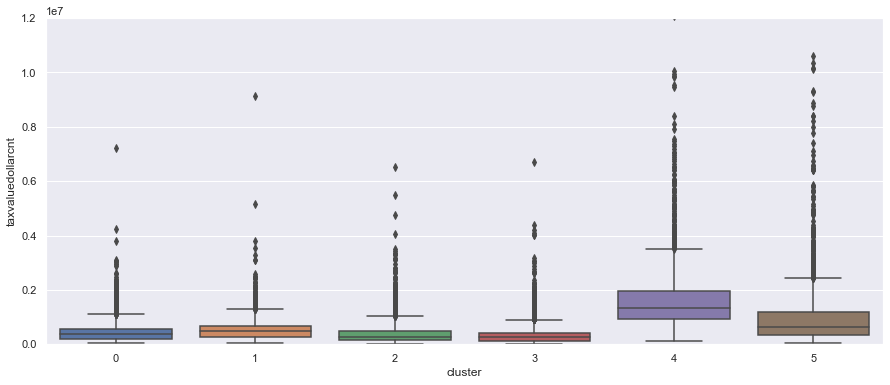

In [42]:
sns.boxplot(data=train, x='cluster', y='taxvaluedollarcnt') # make a boxplot
plt.ylim((0, 1.2e7)) #zoom into the majority of the data

As mentioned in the <a href='#clustering'>clustering</a> section, `yearbuilt` might lead to some level of logerror. 

<AxesSubplot:xlabel='cluster', ylabel='yearbuilt'>

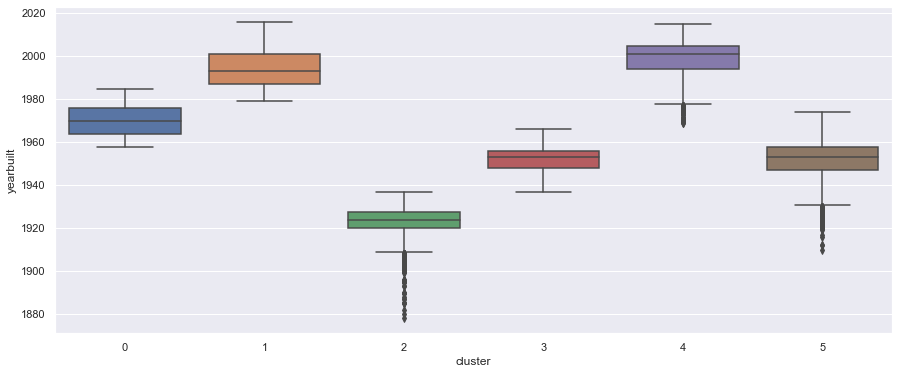

In [43]:
sns.boxplot(data=train, x='cluster', y='yearbuilt') # make a boxplot

It looks like a major part of the clustering was `yearbuilt`, with cluster 2 being older houses, clusters 3 and 4 being newer houses, ans the rest of the clusters being houses from the mid 20th century to the 1980s. Cluster 0, based on the above discussion might also be considered the expenssive mid century houses, and cluster 5 might be expensive modern houses.



#### Hypothesis Testing

*1. Is `logerror` higher in any particular cluster?*

Test the following hypotheses:

$H_0$ : Cluster $x$ an equal or lower mean logerror than not-cluster $x$.

$H_a$ : Clusters $x$ has a greater mean logerror than not-cluster $x$.

Where $x \in [0,5]$

In [52]:
# apply the hypothesis tests
explore_zillow.t_test_by_cat_greater(train, columns_cat=['cluster'], columns_cont = ['logerror']).sort_values('category_name').set_index('category_name')

,column_name,t-stat,p-value,reject_null
category_name,,,,
0,logerror,1.253631,2.100165e-01,False
1,logerror,-0.542625,5.874113e-01,False
2,logerror,-3.337143,8.569093e-04,False
3,logerror,-2.503240,1.232233e-02,False
4,logerror,5.227527,1.946265e-07,True
5,logerror,1.762558,7.811708e-02,True


$H_0$ is rejected for clusters 0, and 1.  This confirms, roughly, what was expected from the above exploration of the clusters.

*2. Is `taxvaluedollarcnt` higher in a particular cluster?*

$H_0$ : Cluster $x$ an equal or lower mean `taxvaluedollarcnt` than not-cluster $x$.

$H_a$ : Clusters $x$ has a greater mean `taxvaluedollarcnt` than not-cluster $x$.

Where $x \in [0,5]$

In [53]:
# apply the hypothesis tests
explore_zillow.t_test_by_cat_greater(train, columns_cat=['cluster'], columns_cont = ['taxvaluedollarcnt']).sort_values('category_name').set_index('category_name')

,column_name,t-stat,p-value,reject_null
category_name,,,,
0,taxvaluedollarcnt,-34.774743,3.350832e-245,False
1,taxvaluedollarcnt,-0.393664,6.938456e-01,False
2,taxvaluedollarcnt,-15.358632,2.805150e-51,False
3,taxvaluedollarcnt,-100.575464,0.000000e+00,False
4,taxvaluedollarcnt,30.138425,3.778447e-158,True
5,taxvaluedollarcnt,17.881652,8.850403e-67,True


$H_0$ is likely true for cluster 1 and cluster 5, but likely false for the other clusters.  Noting the boxplot above, this might be due more to outliers being more extreme in cluster 1 and cluster 5.  Consider the following numeric data which shows that the mean is significantly higher for clusters 0 and 1, but not specifically the extremity of the max for these two clusters:

In [46]:
train.groupby('cluster').taxvaluedollarcnt.describe() #display stats information

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,7255.0,4.263583e+05,3.236196e+05,32434.0,205838.5,377968.0,564645.5,7214000.0
1,5147.0,5.237068e+05,3.558114e+05,43878.0,274000.0,478826.0,685757.0,9120827.0
2,2959.0,4.098518e+05,4.555804e+05,10504.0,144366.0,282000.0,500325.0,6522981.0
3,9799.0,3.253357e+05,2.978060e+05,9242.0,112905.0,275269.0,432655.5,6700650.0
4,1587.0,1.781428e+06,1.756824e+06,106612.0,921196.5,1327391.0,1954086.0,25381250.0
5,2151.0,1.005979e+06,1.346945e+06,54422.0,336348.0,635840.0,1176627.0,23858374.0


*3. Is `yearbuilt` different for the clusters?* 

$H_0$ : Cluster $x$ `yearbuilt` mean is equal to the mean `yearbuilt` of not-cluster $x$.

$H_a$ : Cluster $x$ `yearbuilt` mean is not equal to the mean `yearbuilt` of not-cluster $x$.

Where $x \in [0,5]$

In [54]:
#apply the hypotheses tests
explore_zillow.t_test_by_cat(train, columns_cat = ['cluster'], columns_cont=['yearbuilt']).sort_values('category_name').set_index('category_name')

,column_name,t-test,p-value,reject_null
category_name,,,,
0,yearbuilt,123.512376,0.0,True
1,yearbuilt,334.718320,0.0,True
2,yearbuilt,-298.618676,0.0,True
3,yearbuilt,-302.199212,0.0,True
4,yearbuilt,165.674801,0.0,True
5,yearbuilt,-59.628226,0.0,True


$H_0$ is likely untrue for all hypotheses.  Confirms the data from the visualization.

<a href='#contents'>Back to contents</a>

### Exploring Geographic clusters <a name='geo_clusters'></a>

#### Key Takeaways
- Clusters 1 and 4 have a higher logerror.
- Clusters are still along `yearbuilt`, but less strongly, as geographic data might be more of a pull also
- Clusters 1 and 2 have a higher `taxvaluedollarcnt`, and this looks mainly due to significant outliers within these clusters
- The geographic clusters tend to split along an East/West divide

#### Discussion

In plotting and testing the logerror by the cluster in the geographic data, two of the clusters have a higher logerror. These are clusters that have houses mainly built in the 1960s to 1980s (cluster 1) and houses built in 1950s to 1960 (cluster 4).  This is similar to the non-geographic clustering.  However, the geographic data is still pulling in something because the clusters split stringly by county, and along a East/West split as opposed to a Downtown/Suburbs split in the non-geographic data.  This confirms a decision to do a piecewise model by cluster.

#### Visualization Exploration

(-0.2, 0.2)

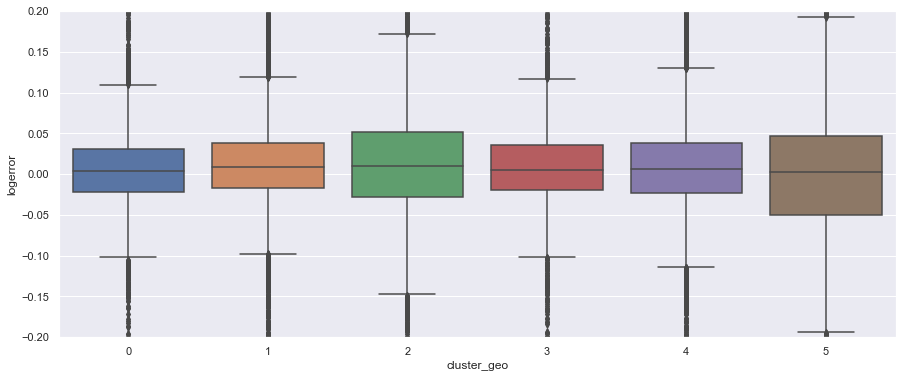

In [87]:
sns.boxplot(data=train, x='cluster_geo', y='logerror') # make a boxplot
plt.ylim((-0.2, 0.2)) # zoom in to see the majority of the data

It looks like clusters 1 and 4 are possibly a little higher because they tend to have a positive imbalance of logerror outliers.

Also note that these look similar to the non-geographic cluster distributions. Apply a similar exploration.

First, see if it is grouping by `yearbuilt`.

<AxesSubplot:xlabel='cluster_geo', ylabel='yearbuilt'>

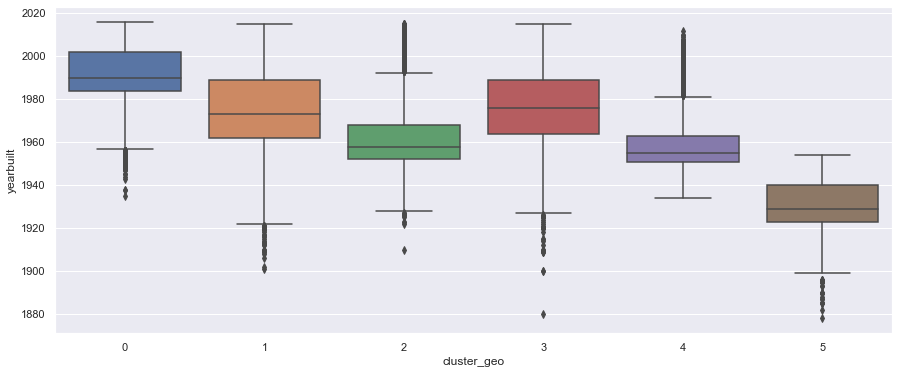

In [89]:
sns.boxplot(data=train, x='cluster_geo', y='yearbuilt') # make a boxplot

It is a tighter grouping than the non-geographic distribution, but there is still a fairly clear `yearbuilt` stratification.  Also consider the `taxvaluedollarcnt`:

(0.0, 10000000.0)

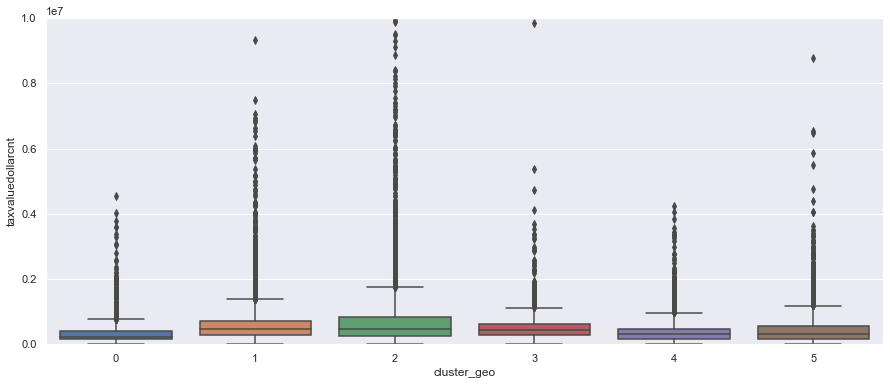

In [91]:
sns.boxplot(data=train, x='cluster_geo', y='taxvaluedollarcnt') # make a boxplot
plt.ylim((0, 1e7)) #zoom into the majority of the data

It looks like clusters 1 and 2 have a higher `taxvaluedollarcnt` (and possibly 3); specifically cluster 2 contains a lot of outliers.  This again looks like an age stratification: cluster 2 captures a lot of homes built around 1960, and cluster 1 captures a lot of home built in the 1980s. Also plot the clusters to see the geographic spread and compare it with the non-geographic clustering:

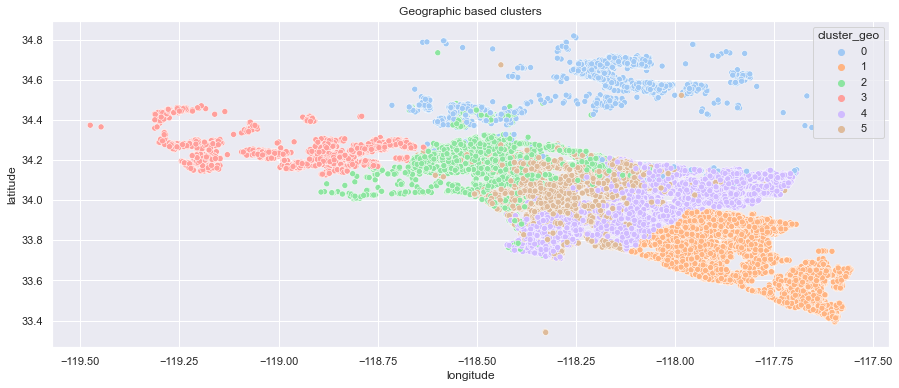

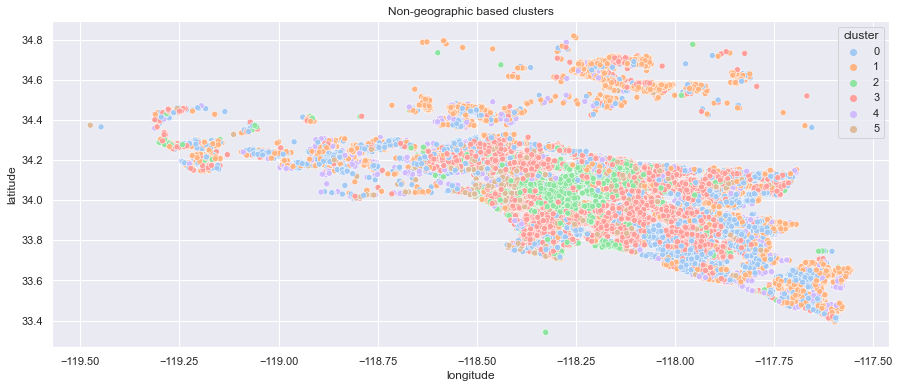

In [71]:
#make a scatter plot for cluster_geo
sns.scatterplot(data=train, x='longitude', y='latitude', hue='cluster_geo', palette = sns.color_palette("pastel", n_colors = 6))
plt.title('Geographic based clusters')
plt.show()
#make a scatter plot for cluster
sns.scatterplot(data=train, x='longitude', y='latitude', hue='cluster', palette = sns.color_palette("pastel", n_colors = 6))
plt.title('Non-geographic based clusters')
plt.show()

There is a similar 'neighborhooding' between both clusters. But the geographic clusters show a more East-West clustering, and Orange county is very clear, whereas non-geographic clusters show a more Downtown-Suburb split. For example, cluster 5 for geographic clusters and cluster 2 for non-geographic clusters look like they overlap.  However, the geographic data is much more concentrated.  Compare when the clusters are plotted individually shows this pattern:

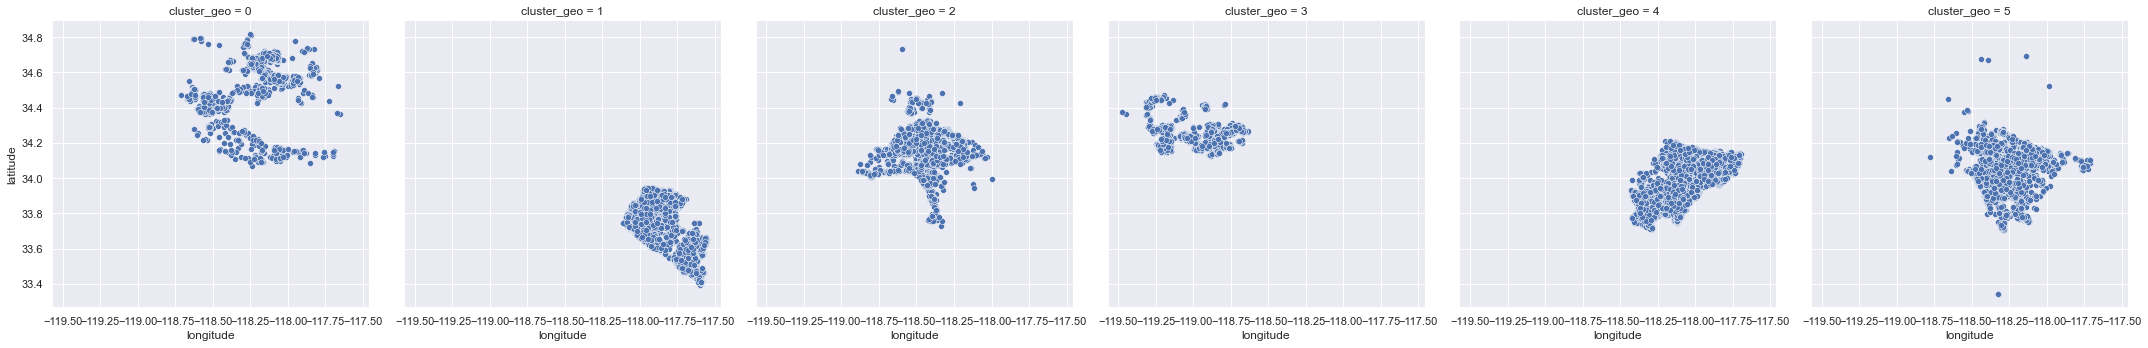

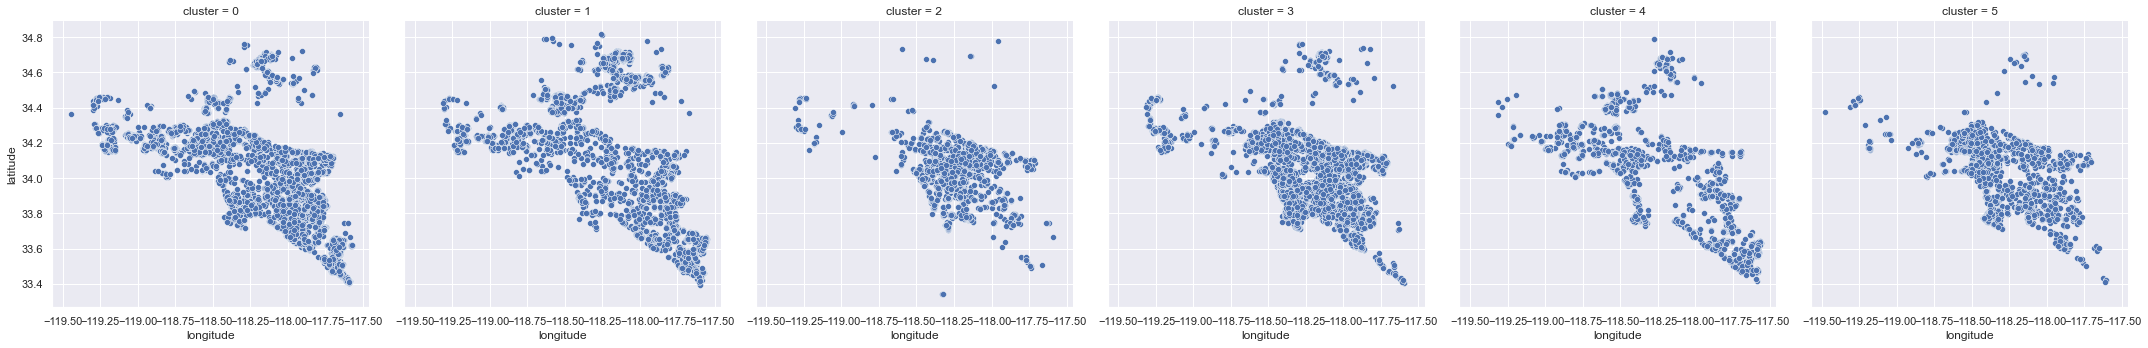

In [76]:
#make a scatter plot for cluster_geo
sns.relplot(data=train, x='longitude', y='latitude', col='cluster_geo', palette = sns.color_palette("pastel", n_colors = 6))
plt.show()
#make a scatter plot for cluster
sns.relplot(data=train, x='longitude', y='latitude', col='cluster', palette = sns.color_palette("pastel", n_colors = 6))
plt.show()

In either case, it would be beneficial to have a piece wise model for the geographic clusters on `clusters_geo`.

#### Hypothesis testing

These are mainly the same as for the non-geographic data.

*1. Is `logerror` higher in any particular cluster_geo?*

Test the following hypotheses:

$H_0$ : Cluster_geo $x$ an equal or lower mean logerror than not-cluster_geo $x$.

$H_a$ : Cluster_geo $x$ has a greater mean logerror than not-cluster_geo $x$.

Where $x \in [0,5]$

In [77]:
# apply the hypothesis tests
explore_zillow.t_test_by_cat_greater(train, columns_cat=['cluster_geo'], columns_cont = ['logerror']).sort_values('category_name').set_index('category_name')

,column_name,t-stat,p-value,reject_null
category_name,,,,
0,logerror,-0.871083,3.837845e-01,False
1,logerror,5.048198,4.561611e-07,True
2,logerror,-0.033339,9.734058e-01,False
3,logerror,-1.804832,7.122305e-02,False
4,logerror,2.913094,3.590578e-03,True
5,logerror,-6.187591,6.625127e-10,False


$H_0$ is rejected for clusters 1, and 4.  This confirms, roughly, what was expected from the above exploration of the clusters.

*2. Is `taxvaluedollarcnt` higher in a particular cluster_geo?*

$H_0$ : Cluster_geo $x$ an equal or lower mean `taxvaluedollarcnt` than not-cluster_geo $x$.

$H_a$ : Cluster_geo $x$ has a greater mean `taxvaluedollarcnt` than not-cluster_geo $x$.

Where $x \in [0,5]$

In [79]:
# apply the hypothesis tests
explore_zillow.t_test_by_cat_greater(train, columns_cat=['cluster_geo'], columns_cont = ['taxvaluedollarcnt']).sort_values('category_name').set_index('category_name')

,column_name,t-stat,p-value,reject_null
category_name,,,,
0,taxvaluedollarcnt,-32.910147,9.517413e-201,False
1,taxvaluedollarcnt,14.502874,4.787657e-47,True
2,taxvaluedollarcnt,17.830526,8.659646e-69,True
3,taxvaluedollarcnt,-1.828240,6.763446e-02,False
4,taxvaluedollarcnt,-49.117409,0.000000e+00,False
5,taxvaluedollarcnt,-12.715975,1.894806e-36,False


$H_0$ is likely false for clusters 1 and 2. This confirms what was seen in the visualization analysis.

*3. Is `yearbuilt` different for the clusters?* 

$H_0$ : Cluster $x$ `yearbuilt` mean is equal to the mean `yearbuilt` of not-cluster $x$.

$H_a$ : Cluster $x$ `yearbuilt` mean is not equal to the mean `yearbuilt` of not-cluster $x$.

Where $x \in [0,5]$

In [80]:
#apply the hypotheses tests
explore_zillow.t_test_by_cat(train, columns_cat = ['cluster_geo'], columns_cont=['yearbuilt']).sort_values('category_name').set_index('category_name')

,column_name,t-test,p-value,reject_null
category_name,,,,
0,yearbuilt,91.826176,0.000000e+00,True
1,yearbuilt,75.630676,0.000000e+00,True
2,yearbuilt,-5.086939,3.785659e-07,True
3,yearbuilt,36.385482,2.319845e-232,True
4,yearbuilt,-38.378588,2.796448e-291,True
5,yearbuilt,-228.185077,0.000000e+00,True


$H_0$ is likely false for all the clusters, implying the clusters are stratifying by year built.


<a href='#contents'>Back to contents</a>